In [1]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 25.1 MB/s eta 0:00:00


Uploading and reading PDF files

In [2]:
#importing the dependencies

import os
import fitz # PyMuPDF
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from google.colab import files

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify your folder path
folder_path = '/content/drive/MyDrive/Pdf dataset'
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract text from PDF files

In [3]:
def extract_text_from_pdfs(folder_path, pdf_files):
    texts = []
    for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)
        try:
            doc = fitz.open(pdf_path)

            # Check if the document is encrypted
            if doc.is_encrypted:
                print(f"Skipping encrypted file: {pdf_file}")
                continue  # Skip to the next file

            text = ""
            for page in doc:
                text += page.get_text()
            texts.append(text)

        except RuntimeError as e:
            print(f"MuPDF RuntimeError for {pdf_file}: {e}")
        except Exception as e:
            print(f"Error processing {pdf_file}: {e}")

    return texts


texts = extract_text_from_pdfs(folder_path, pdf_files)

Skipping encrypted file: 4GJGAIUVBMLM3W7O5SV4EKDNKC4DVOCL.pdf
MuPDF RuntimeError for 6HTC5FVAQW3DVHYRD7PVJGBBQS7GRZTL.pdf: Failed to open file '/content/drive/MyDrive/Pdf dataset/6HTC5FVAQW3DVHYRD7PVJGBBQS7GRZTL.pdf'.
MuPDF error: format error: No default Layer config

MuPDF error: format error: No default Layer config

MuPDF error: format error: No default Layer config

MuPDF error: format error: No default Layer config

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: non-page object in page tree

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: object out of range (1167 0 R); xref size 1167

MuPDF error: format error: object out of range (1167 0 R); xref siz

Defining keyword of clusters for interpretation

In [4]:
topic_keywords = {
    "science": ["experiment", "research", "theory", "biology", "physics", "chemistry"],
    "technology": ["technology", "software", "hardware", "computer", "internet", "device"],
    "history": ["history", "ancient", "war", "empire", "revolution", "historical"],
    "literature": ["literature", "poetry", "novel", "author", "fiction", "literary"],
    "business": ["market", "finance", "economy", "profit", "investment", "industry"]
}

Pre-Process text data

In [5]:
# Basic text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Preprocess all texts
cleaned_texts = [preprocess_text(text) for text in texts if text]  # only non-empty texts

# Ensure cleaned_texts and pdf_files are the same length

pdf_files_filtered = [pdf_files[i] for i in range(len(pdf_files)) if i < len(cleaned_texts)] # Filter out pdf_files entries where text extraction might have failed

# Convert the texts into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(cleaned_texts)


Applying KMeans clustering

In [6]:
# Set the number of clusters (topics)
num_clusters = len(topic_keywords)  # Using the number of defined topics
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

Add Cluster Labels to DataFrame

In [7]:
# Create a DataFrame to store PDF files and their cluster labels
clustered_df = pd.DataFrame({'PDF File': pdf_files_filtered, 'Cluster': labels})
print(clustered_df.head())

                               PDF File  Cluster
0  47HBHTDSTAKCJIYQ22345FHWVNVJMXJL.pdf        4
1  46ZGYJDQNL2COPU447ILTCZ6EUMSQOHA.pdf        4
2  3WVRGDKMXZRPVBBNRYOLXY3J3VIZROXI.pdf        4
3  3RCHLDD2YCPDNLHEV4AVKEPBYJP5UBZB.pdf        4
4  4RPOXAYQCNHNFQZMBDNNZAZUSVYDBPQJ.pdf        4


Interpret clusters by keywords

In [8]:
# Define the mapping of cluster indices to topic names
# Assuming clusters correspond to:
# 0: science, 1: technology, 2: history, 3: literature, 4: business
cluster_names = {
    0: "science",
    1: "technology",
    2: "history",
    3: "literature",
    4: "business"
}

# Retrieve terms from the TF-IDF vectorizer for cluster interpretation
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    # Get indices of the top terms for each cluster
    top_term_indices = np.argsort(kmeans.cluster_centers_[i])[-10:]
    top_terms = [terms[ind] for ind in top_term_indices[::-1]]
    print(f"Cluster {i} top terms:", top_terms)

    # Print the topic name assigned to this cluster
    assigned_topic = cluster_names.get(i, "Unknown")
    print(f"Cluster {i} represents: {assigned_topic}")
    print()

# Map the cluster labels to their assigned topic names in the DataFrame
clustered_df['Topic'] = clustered_df['Cluster'].map(cluster_names)

# Preview the DataFrame to verify topics
print(clustered_df[['PDF File', 'Cluster', 'Topic']].head())


Cluster 0 top terms: ['shall', 'section', 'date', 'information', 'fr', 'des', 'act', 'notice', 'federal', 'code']
Cluster 0 represents: science

Cluster 1 top terms: ['data', 'school', 'humanitarian', 'students', 'model', 'target', 'district', 'indicator', 'disabilities', 'centre']
Cluster 1 represents: technology

Cluster 2 top terms: ['court', 'motion', 'district', 'united', 'states', 'rule', 'defendant', 'case', 'fd', 'filed']
Cluster 2 represents: history

Cluster 3 top terms: ['ky', 'la', 'cvrcjwgc', 'datos', 'los', 'repealed', 'acts', 'ch', 'sec', 'para']
Cluster 3 represents: literature

Cluster 4 top terms: ['health', 'care', 'total', 'state', 'program', 'county', 'congressman', 'new', 'house', 'million']
Cluster 4 represents: business

                               PDF File  Cluster     Topic
0  47HBHTDSTAKCJIYQ22345FHWVNVJMXJL.pdf        4  business
1  46ZGYJDQNL2COPU447ILTCZ6EUMSQOHA.pdf        4  business
2  3WVRGDKMXZRPVBBNRYOLXY3J3VIZROXI.pdf        4  business
3  3RCHLD

Data Visualizatin of clusters

<ipython-input-15-28cc909ef54d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=clustered_df, x='Cluster', palette='husl')


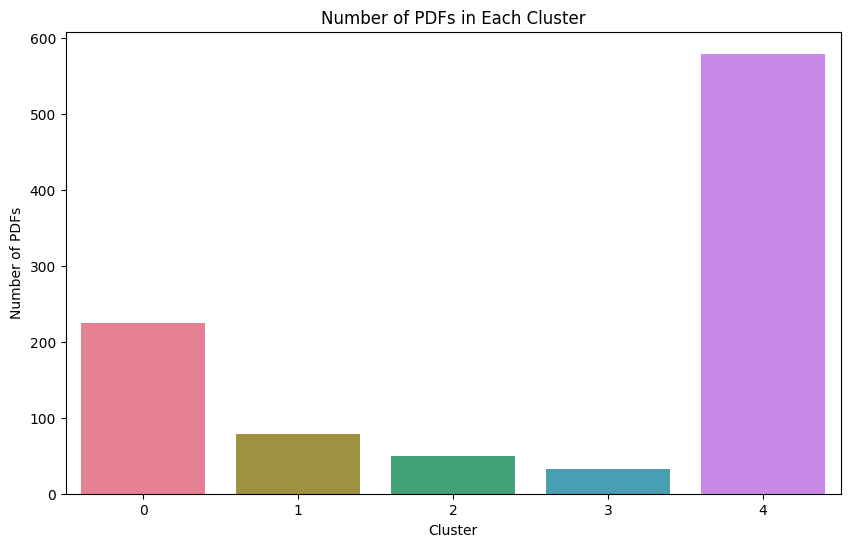

In [15]:
#importing the dependencies for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the number of PDFs in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=clustered_df, x='Cluster', palette='husl')
plt.title('Number of PDFs in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of PDFs')
plt.show()

Saving and downloading the model



In [17]:
# Saving the KMeans model and TF-IDF vectorizer
with open('/content/kmeans_model.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

with open('/content/vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save the topic mapping dictionary
with open('/content/cluster_names.pkl', 'wb') as names_file:
    pickle.dump(cluster_names, names_file)

# Downloading the saved pickle files
files.download('/content/kmeans_model.pkl')
files.download('/content/vectorizer.pkl')
files.download('/content/cluster_names.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>